<a href="https://colab.research.google.com/github/jonathanmaxberman/Handwriting-synthesis/blob/master/GeneratePrimingFiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Priming**
Enter a short string of characters to act as a priming sequnce. Draw in the HTML canvas handwriting to produce the priming data. Move generated files to the "styles" folder with a unique style number.

In [19]:
from io import RawIOBase
import numpy as np
import ipywidgets as widgets
import drawing
from IPython.display import display, Javascript, HTML
from google.colab import output
import json
from google.colab import files

# Import necessary functions from the library
from drawing import align, denoise, coords_to_offsets, normalize

np.set_printoptions(suppress=True, precision=8, floatmode='fixed')



def handle_draw_data(data):
    # Decode the JSON data
    draw_data = json.loads(data)
    strokes = np.array(draw_data, dtype=np.float64)
    # Process the strokes data using the library functions
    #strokes = strokes.astype(np.float32)
    canvas_height = 200
    strokes[:, 1] = canvas_height - strokes[:,1]

    strokes = align(strokes)
    strokes = denoise(strokes)
    offsets = coords_to_offsets(strokes)
    normalized_strokes = normalize(offsets)

    # Truncate or pad the data as needed (assuming MAX_STROKE_LEN is defined in the library)
    normalized_strokes = normalized_strokes[:drawing.MAX_STROKE_LEN]
    if len(normalized_strokes) < drawing.MAX_STROKE_LEN:
        padding = np.zeros((drawing.MAX_STROKE_LEN - len(normalized_strokes), 3))
        normalized_strokes = np.vstack((normalized_strokes, padding))
    # Save the normalized strokes data as a .npy file
    normalized_strokes = normalized_strokes.astype(np.float32)
    np.save('style-13-strokes.npy', normalized_strokes)
    print("Normalized strokes data saved.")

    # Get the priming sequence from the text widget and encode it as a byte string
    priming_sequence = text.value.encode()

    # Convert the byte string to a numpy array
    #char_array = np.frombuffer(priming_sequence, dtype=np.uint8)

    # Save the priming sequence as a .npy file
    np.save('style-13-chars.npy', priming_sequence)
    print("Priming sequence saved.")

    # Download the files to your local machine
    files.download('style-13-strokes.npy')
    files.download('style-13-chars.npy')

# Create a textbox for the priming sequence
text = widgets.Text(description='Priming Sequence:')
display(text)


# Create a canvas for drawing
canvas_html = """

<canvas id="canvas" width="800" height="200" style="border:1px solid black;"></canvas>
<button id="sendData">Send Data</button>

<script>
    var canvas = document.getElementById('canvas');
    var ctx = canvas.getContext('2d');

    var mousePressed = false;
    var strokeData = [];

    canvas.addEventListener('mousedown', function(e) {
        mousePressed = true;
        var x = e.pageX - this.offsetLeft;
        var y = e.pageY - this.offsetTop;
        draw(x, y, false);
        strokeData.push([x, y, 0]); // Start of a new stroke
    });

    canvas.addEventListener('mousemove', function(e) {
        if (mousePressed) {
            var x = e.pageX - this.offsetLeft;
            var y = e.pageY - this.offsetTop;
            draw(x, y, true);
            strokeData.push([x, y, 0]); // Continue the stroke
        }
    });

    canvas.addEventListener('mouseup', function(e) {
        mousePressed = false;
        var x = e.pageX - this.offsetLeft;
        var y = e.pageY - this.offsetTop;
        strokeData.push([x, y, 1]); // End of the stroke
    });

    canvas.addEventListener('mouseleave', function(e) {
        mousePressed = false;
    });

    function draw(x, y, isDown) {
        if (isDown) {
            ctx.beginPath();
            ctx.strokeStyle = 'black';
            ctx.lineWidth = 2;
            ctx.lineJoin = 'round';
            ctx.moveTo(strokeData[strokeData.length - 1][0], strokeData[strokeData.length - 1][1]); // Move to the last point
            ctx.lineTo(x, y);
            ctx.closePath();
            ctx.stroke();
        }
    }

    document.getElementById('sendData').addEventListener('click', function() {
        console.log(JSON.stringify(strokeData));

        // Send the stroke data to the Python function for further processing
        google.colab.kernel.invokeFunction('notebook.handle_draw_data', [JSON.stringify(strokeData)], {});
        strokeData = [];
        ctx.clearRect(0, 0, canvas.width, canvas.height);
    });
</script>


"""
display(HTML(canvas_html))

# Register the callback function
output.register_callback('notebook.handle_draw_data', handle_draw_data)

Text(value='', description='Priming Sequence:')

Normalized strokes data saved.
Priming sequence saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Examine the contents of numpy files.

In [ ]:
# Load the .npy file
file_path = '/content/style-9-strokes.npy'  # Replace with the actual path to your .npy file
data = np.load(file_path, allow_pickle=True, encoding='bytes')

# Print the content of the NumPy array
print(data, data.dtype)

[[ 0.00000000  0.00000000  1.00000000]
 [ 0.02137598 -0.05878394  0.00000000]
 [ 0.00000000 -0.00534400  0.00000000]
 ...
 [-0.51836753 -1.24158823  0.00000000]
 [-0.36161032 -1.19527352  0.00000000]
 [-0.18525849 -0.91738582  0.00000000]] float32


Examine the writing in a style .npy file.

In [14]:
pip install svgwrite

[[ 1.00000000  0.00000000  0.00000000]
 [ 0.00000000  0.01493014 -1.05920172]
 [ 0.00000000  0.02421103 -1.71762443]
 ...
 [ 0.00000000  0.00000000  0.00000000]
 [ 0.00000000  0.00000000  0.00000000]
 [ 0.00000000  0.00000000  0.00000000]]


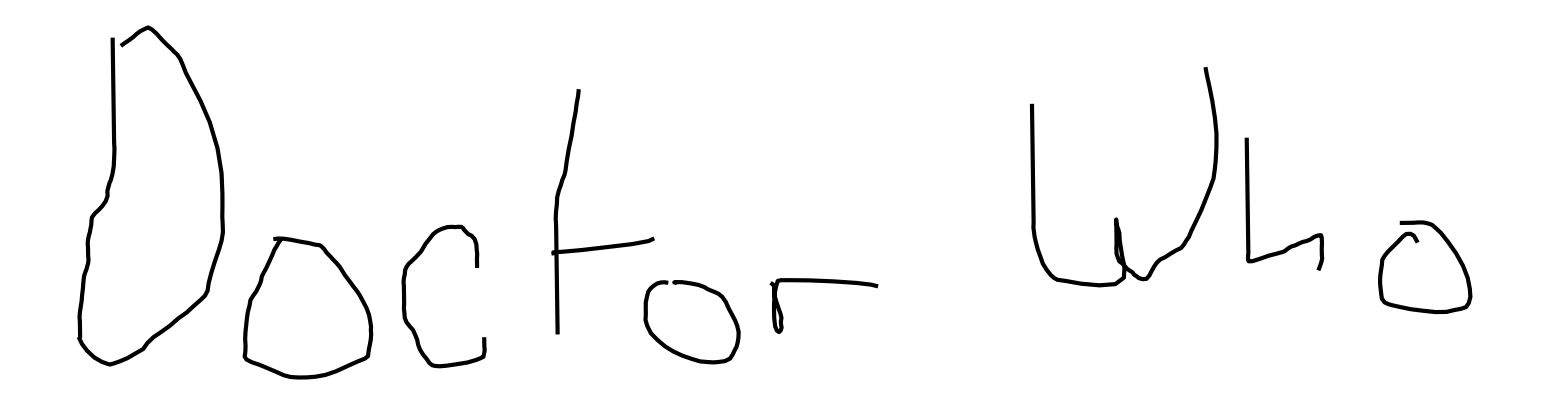

In [20]:
import matplotlib
from matplotlib import pyplot

import svgwrite
import numpy as np
from IPython.display import SVG, display

def plot_stroke(stroke, save_name=None):
    # Plot a single example.
    f, ax = pyplot.subplots()

    x = np.cumsum(stroke[:, 1])
    y = np.cumsum(stroke[:, 2])

    size_x = x.max() - x.min() + 1.0
    size_y = y.max() - y.min() + 1.0

    f.set_size_inches(5.0 * size_x / size_y, 5.0)

    cuts = np.where(stroke[:, 0] == 1)[0]
    start = 0

    for cut_value in cuts:
        ax.plot(x[start:cut_value], y[start:cut_value], "k-", linewidth=3)
        start = cut_value + 1

    ax.axis("off")  # equal
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if save_name is None:
        pyplot.show()
    else:
        try:
            pyplot.savefig(save_name, bbox_inches="tight", pad_inches=0.5)
        except Exception:
            print("Error building image!: " + save_name)

    pyplot.close()

def rearrange_strokes(data):
    # Extract up/down, x, and y from the data
    up_down = data[:, 2]  # Extract up/down values from the third column
    x = data[:, 0]       # Extract x values from the first column
    y = data[:, 1]       # Extract y values from the second column

    # Create a new array with the rearranged format "up/down, x, y"
    rearranged_data = np.column_stack((up_down, x, y))

    return rearranged_data


file_path = '/content/style-13-strokes.npy'
stroke_data = np.load(file_path)
rearranged_strokes = rearrange_strokes(stroke_data)
print(rearranged_strokes)
plot_stroke(rearranged_strokes)